Import All Required Libraries

In [1]:
#Code : Imports
import json
import os
from langdetect import detect as detectlang, DetectorFactory
DetectorFactory.seed = 0
#from textblob import TextBlob
import zipfile
import pandas as pd
import seaborn as  sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
import re
%matplotlib inline
import warnings; warnings.simplefilter('ignore')


# Helper Functions

Below cell has helper functions for extraction information about hashtags

In [2]:
#Code Helper Functions Hashtag Extraction

#Updates HashTag Dictionary
def UpdateHasttagDict(htlist, hashtags):
    curr_doc_counts = {}
    for t in htlist:
        tlower = t.lower()
        curr_doc_counts[tlower] = curr_doc_counts.get(tlower,0)+1
    
    for ht,doccnt in curr_doc_counts.items():
        if ht in hashtags:
            hashtags[ht]['tf'] +=doccnt
            hashtags[ht]['df'] +=1            
        else:
            hashtags[ht] = {'tf' :doccnt , 'df': 1}
    return hashtags
    
    
    
#Extracts HashTags from given text passed as input
def ExtractHashTags(text):
    htpattern = r"#\w+"
    htlist = re.findall(htpattern,text)
    return htlist
    
    
# Extract hahstags from JSON as well as text anc compare for mismatches
def ExtractHTInfo(tjson, hashtags, regex_doesntmatch):
    tweet_text = tjson['full_text'].replace('\n',' ').strip()
    
    #Extract HTS from JSON
    htjsonlist = ['#'+ht['text'] for ht in tjson['entities']['hashtags']]
    
    #Extract HTS from Based on regex    
    htregexlist = ExtractHashTags(tweet_text)
    
    
    #ValidateRegex
    setdiffA = set(htjsonlist) - set(htregexlist)
    setdiffB = set(htregexlist) - set(htjsonlist)
    validate_regex = len(setdiffA) + len(setdiffB) + len(htjsonlist) - len(htregexlist)
    if(validate_regex !=0):
        link = 'https://twitter.com/' +tjson['user']['screen_name']+'/status/' + tjson['id_str']
        regex_doesntmatch.append((setdiffA,setdiffB, link, tweet_text))
        
    hashtags = UpdateHasttagDict(htregexlist, hashtags)
    #hashtags = UpdateHasttagDict(htjsonlist, hashtags)
    
    
    return hashtags,regex_doesntmatch

Below cell has helper functions for finding the language of the tweets

In [3]:
# Code Helper Function to Resolve Language
def ResolveLanguage(shortname, langconfig):
    for l in langconfig:
        if shortname==l['code']:
            return l['name']
    return shortname
    

Below cell has helper functions for convert a dictionary to dataframe

In [4]:
# Code: Helper function to convert a dictionary to dataframe
def Dicttodataframe(dictin, idxname, columnsin = None):
    df =pd.DataFrame.from_dict(dictin, orient='index')
    if columnsin:
        df.columns = columnsin
    df.index.name = idxname
    df= df.reset_index()
    return df


# Extract Info from Tweets to Prepare Data

In [5]:
# Code Extract Information and Prepare Data also reports any issues
datafolder ='Data/'
jsonfolder='/JSON/'
zippedfilepath = 'JSON.zip'

orig_htlist = ['service', 'price', 'cost', 'quality', 'ambiente', 'reservation']
langconfig = None
with open('langconfig.json', 'r') as f:
    langconfig = json.load(f)

hashtagsdict  = {}
langdict = {}
langdictJSON = {}
regex_doesntmatch = []


if zippedfilepath:
    zippedFolder = zipfile.ZipFile(datafolder + zippedfilepath, 'r')
    tweetjsonfiles = zippedFolder.infolist()
else:
    tweetjsonfiles = os.listdir(datafolder + jsonfolder)

for tweetfile in tweetjsonfiles:
    if zippedfilepath:
        currjson = json.loads(zippedFolder.open(tweetfile).read())    
    else:
        currjson = json.loads(open(datafolder + jsonfolder + tweetfile).read())    
    hashtagsdict,regexfailed = ExtractHTInfo(currjson, hashtagsdict,regex_doesntmatch)
    #lang= TextBlob(currjson['full_text']).detect_language()
    
    
    lang =  ResolveLanguage(detectlang(currjson['full_text']), langconfig)
    langdict[lang] = langdict.get(lang,0) +1
    
    langjson = ResolveLanguage(currjson['lang'],langconfig)
    langdictJSON[langjson] = langdictJSON.get(langjson,0) +1
    
    

print("Total tweets processed " , len(tweetjsonfiles) )
print( "Tweets for which original hashtags are different from regex hashtags" , len(regex_doesntmatch))
# for ht, val in hashtags.items():
#     print(ht, val['tf'], val['df'])

Total tweets processed  1550
Tweets for which original hashtags are different from regex hashtags 31


Prints Information about tweets for which regular expressions does not match

In [6]:
# Code for printing info about Tweets for which regex doesnt match
print(len(regex_doesntmatch))
for rf in regex_doesntmatch:
    print("HT in JSON but was not found in regex filtering:", rf[0])
    print("HT not in JSON but was found in regex filtering:", rf[1])
    print("Tweet Link", rf[2])
    print()


31
HT in JSON but was not found in regex filtering: {'#ಕೆಟಿಎಂ'}
HT not in JSON but was found in regex filtering: {'#ಕ'}
Tweet Link https://twitter.com/OneindiaKannada/status/1092330424985108480

HT in JSON but was not found in regex filtering: {'#ಹೋಂಡಾ'}
HT not in JSON but was found in regex filtering: {'#ಹ'}
Tweet Link https://twitter.com/OneindiaKannada/status/1093799786917052417

HT in JSON but was not found in regex filtering: {'#सहेली', '#कड़क'}
HT not in JSON but was found in regex filtering: {'#personalityऔर', '#कड', '#सह'}
Tweet Link https://twitter.com/sameermughal533/status/1094639993186803713

HT in JSON but was not found in regex filtering: {'#नोटा', '#मनुवादी_सवर्ण_गब्बर'}
HT not in JSON but was found in regex filtering: {'#मन', '#न'}
Tweet Link https://twitter.com/Pradeep723pk/status/1092521245852164098

HT in JSON but was not found in regex filtering: {'#கலைஞர்'}
HT not in JSON but was found in regex filtering: {'#கல'}
Tweet Link https://twitter.com/ShotDKuruvi/status/10

# PLOTS

Distribution for Top 10 Languages most represented in the Tweets (Based on Detection Library)

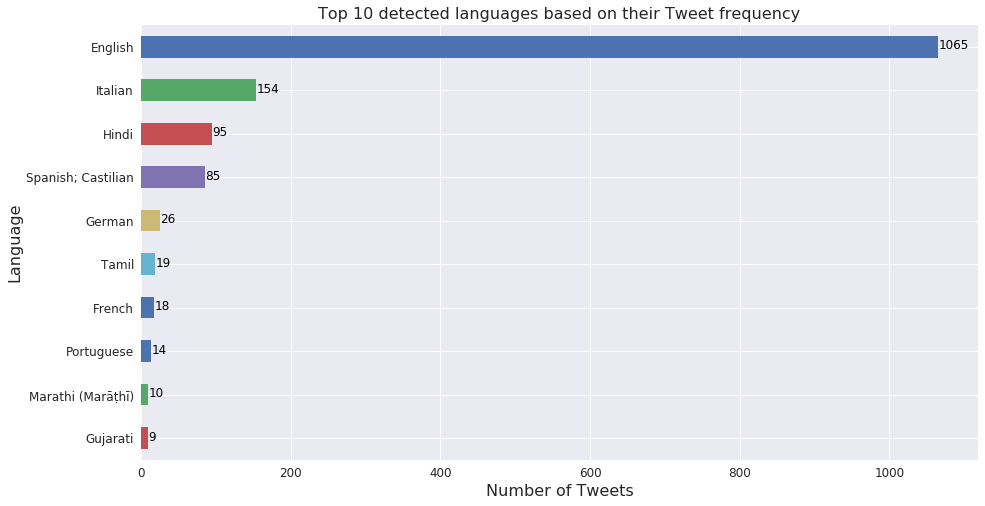

In [7]:
#Code For Plotting Language Frequeny Detected Using Helper Library
langdf = Dicttodataframe(langdict, 'Language',['count'])
top10languages = langdf.sort_values(by="count", ascending=False).iloc[0:10]

#NORMAL PLOT
title = "Top 10 detected languages based on their Tweet frequency"
ax = top10languages.plot(x='Language', y='count', kind ='barh', figsize=(15,8), grid = True, sort_columns= False,  legend = False)
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_xlabel("Number of Tweets", fontsize= '16') 
ax.set_ylabel("Language", fontsize= '16') 
ax.set_title(title, fontsize = '16')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.2, i.get_y()+.3, \
            str(round((i.get_width()), 3)), fontsize= 12, color='black')
ax.invert_yaxis()



Distribution for Top 10 Languages most represented in the Tweets (Based on Language present in JSON)

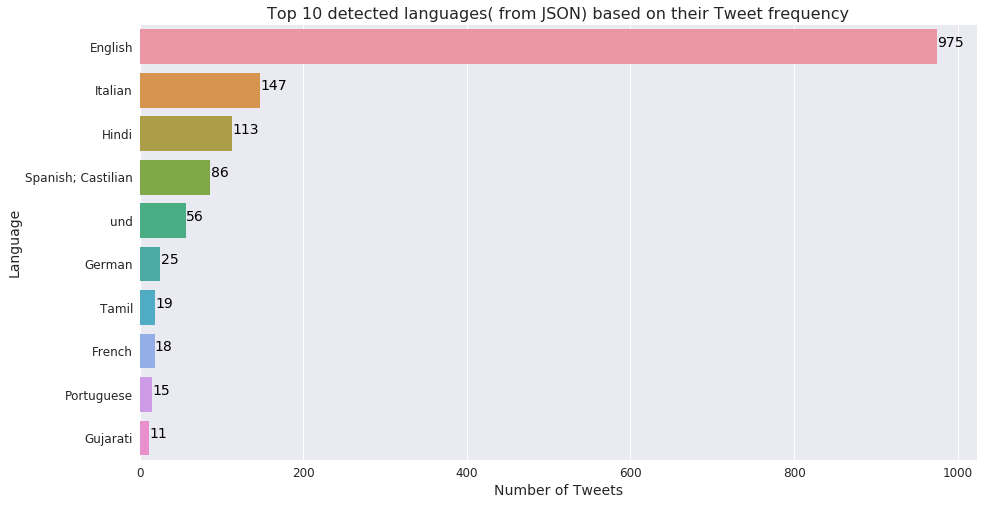

In [8]:
#Code For Plotting Language Frequeny Detected Using JSON Information
langdfJSON = Dicttodataframe(langdictJSON, 'Language',['count'])
top10languagesJSON = langdfJSON.sort_values(by="count", ascending=False).iloc[0:10]

#SNS BASEAD Plot
plt.figure(figsize=(15,8))
title = "Top 10 detected languages( from JSON) based on their Tweet frequency"
ax= sns.barplot("count", "Language", data=top10languagesJSON, orient="h")
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_xlabel("Number of Tweets", fontsize= '14') 
ax.set_ylabel("Language", fontsize= '14') 
ax.set_title(title, fontsize = '16')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.4, \
            str(int(round((i.get_width()), 4))), fontsize= 14, color='black')
                              


Frequency Distribution for Top 50 Hashtags (other than search terms) most represented in the Tweets (based on their total occurence)

In [9]:
#Code to get  top 50 Hashtags other than search keywords
htdf = Dicttodataframe(hashtagsdict, 'HashTag')
ignore_filter = ~htdf['HashTag'].isin(['#'+w for w in orig_htlist])
top50 = htdf[ignore_filter].sort_values(by="df", ascending=False).iloc[0:50]


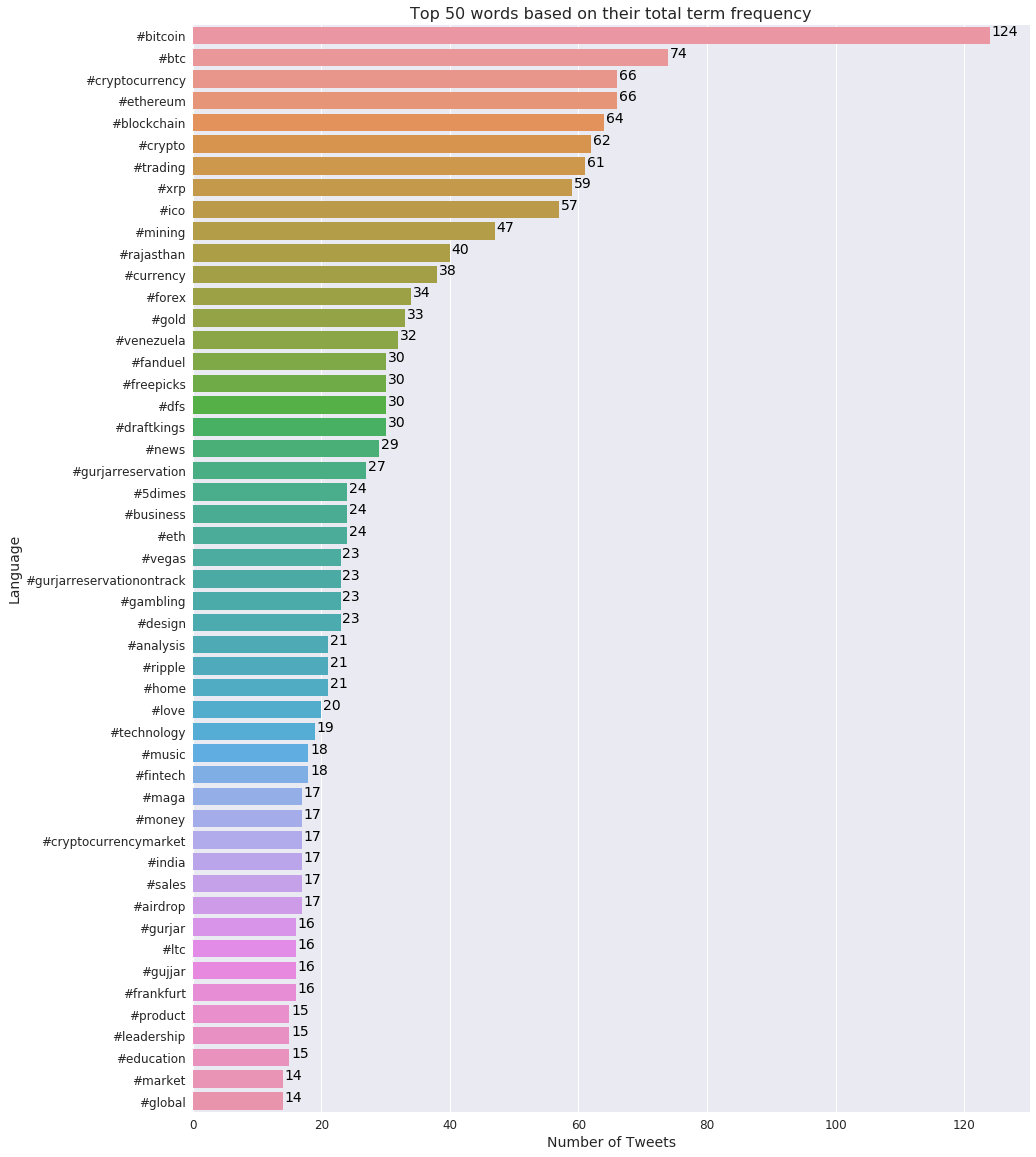

In [10]:
#Code to Plot top 50 Hashtag frequencies based on total frequency
plt.figure(figsize=(15,20))
title = "Top 50 words based on their total term frequency"
ax = sns.barplot("tf", "HashTag", data=top50, orient="h")
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_xlabel("Number of Tweets", fontsize= '14') 
ax.set_ylabel("Language", fontsize= '14') 
ax.set_title(title, fontsize = '16')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.4, \
            str(int(round((i.get_width()), 4))), fontsize= 14, color='black')
                              


Frequency Distribution for Top 50 Hashtags (other than search terms) most represented in the Tweets (based on their dcoument frequency)

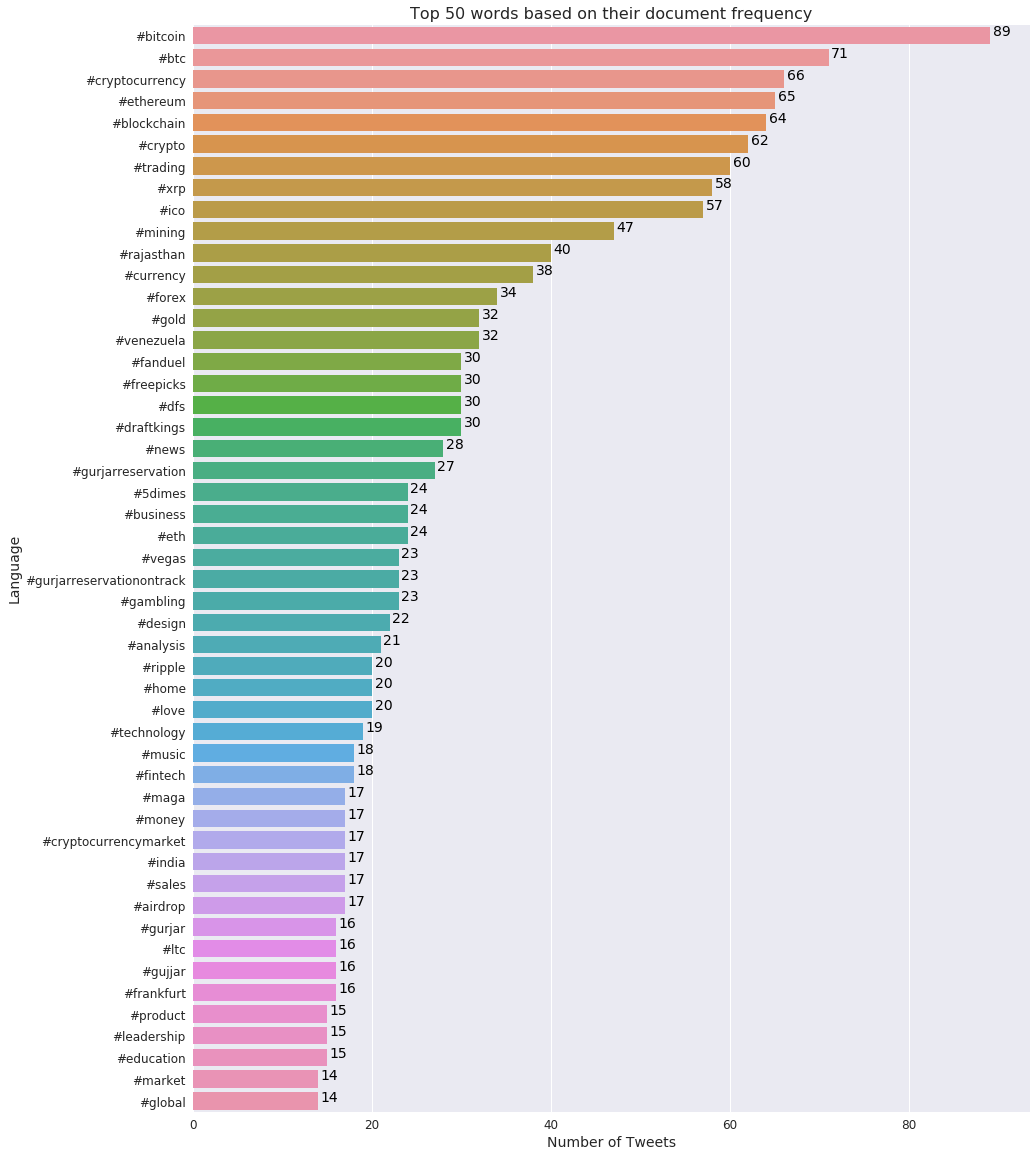

In [11]:
#Code to Plot top 50 frequencies based on document frequency
plt.figure(figsize=(15,20))
title = "Top 50 words based on their document frequency"
ax = sns.barplot("df", "HashTag", data=top50, orient="h")
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_xlabel("Number of Tweets", fontsize= '14') 
ax.set_ylabel("Language", fontsize= '14') 
ax.set_title(title, fontsize = '16')
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.4, \
            str(int(round((i.get_width()), 4))), fontsize= 14, color='black')


# Optional

Below Code Load all Tweet JSONs in a dataframe and also set the class to be predicted

In [12]:
# Code for JSONs to Dataframe
from pandas.io.json import json_normalize
tweetsDF = pd.DataFrame()
for tweetfile in tweetjsonfiles:
    if zippedfilepath:
        currjson = json.loads(zippedFolder.open(tweetfile).read())    
    else:
        currjson = json.loads(open(datafolder + jsonfolder + tweetfile).read())    
    currtweetDF = json_normalize(currjson)
    tweetsDF = tweetsDF.append(currtweetDF)
  

In [13]:
# Code to set Sentiment Class for each tweet
def getClass(fav):
    if fav<=4:
        return "NEGATIVE"
    elif fav>10:
        return "POSITIVE"
    else:
        return "NEUTRAL"
tweetsDF['sentiment'] = tweetsDF['favorite_count'].apply(getClass)

Distribution of No of Tweets w.r.t How they have been liked

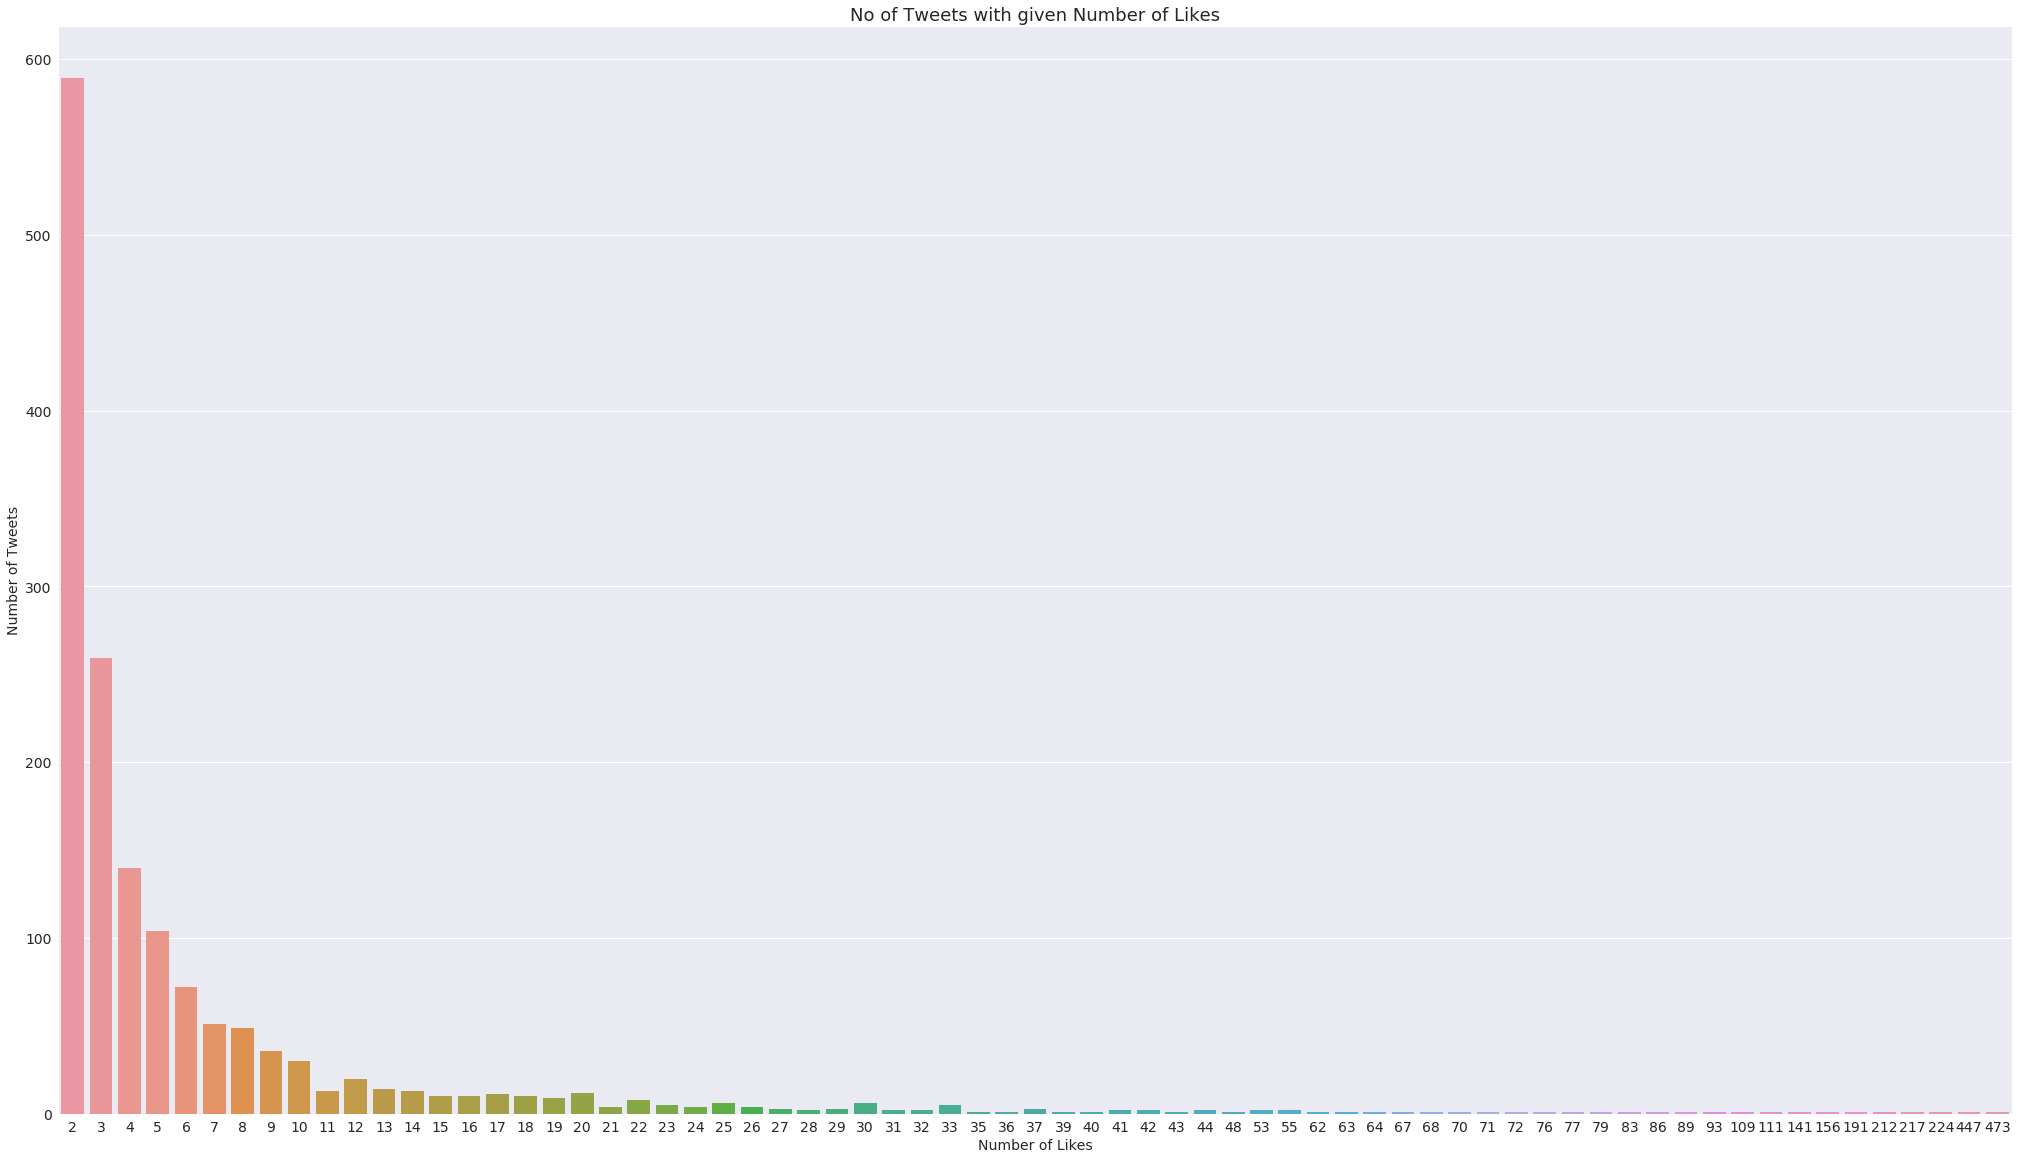

In [14]:
#Code to Plot distribution of Likes
title = 'No of Tweets with given Number of Likes'
plt.figure(figsize=(35,20))
ax =sns.countplot(tweetsDF.favorite_count)
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_xlabel("Number of Likes", fontsize= '14') 
ax.set_ylabel("Number of Tweets", fontsize= '14') 
ax.set_title(title, fontsize = '18')
plt.show()

Distribution of No of Sentiment Classes

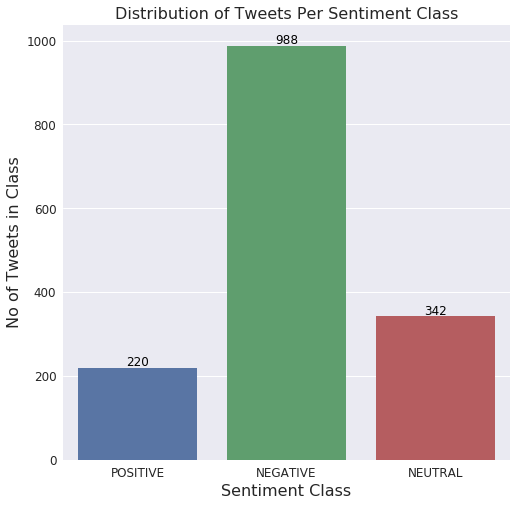

In [15]:
#Code to Plot Sentiment Class Distribution
plt.figure(figsize=(8,8))
title = 'Distribution of Tweets Per Sentiment Class'
sns.set(style="darkgrid")

ax =sns.countplot(tweetsDF['sentiment'])
ax.yaxis.set_tick_params(labelsize=12)
ax.xaxis.set_tick_params(labelsize=12)
ax.set_xlabel("Sentiment Class", fontsize= '16') 
ax.set_ylabel("No of Tweets in Class", fontsize= '16') 
ax.set_title(title, fontsize = '16')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 5,
            height,
            ha="center",  fontsize= 12, color='black') 

    